This notebook addresses requirements  [LVV-308](https://jira.lsstcorp.org/browse/LVV-308) and [LVV-309](https://jira.lsstcorp.org/browse/LVV-309?filter=23354)
covered in test cases [LVV-T2846](https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/3262) and [LVV-T2847](https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/3263).

These requirements define the area on sky to be covered in the survey and the number of visits per pointing over this 'main' part of the survey, as well as how much sky should be covered with 'rapid time coverage'. 

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rubin_sim.maf as maf

import rubin_sim
rubin_sim.__version__

'1.1.2.dev77+g199a770'

### Calculate Metrics ###

Identify the baseline survey simulation, currently `baseline_v3.2_10yrs`, which is the current example of an implemented survey strategy.

In [2]:
# Download and write to current directory, if does not exist
run_name = 'baseline_v3.2_10yrs'
dbfile = f"{run_name}.db"

url_baseline = "https://s3df.slac.stanford.edu/data/rubin/sim-data/"
url_baseline += "sims_featureScheduler_runs3.2/baseline/baseline_v3.2_10yrs.db"

if not(os.path.isfile(dbfile)):
    print(f'Downloading {run_name} from {url_baseline}')

    from urllib.request import urlopen

    with urlopen(url_baseline) as file:
        content = file.read()
    with open(dbfile, 'wb') as download:
        download.write(content)

print(f'Using {run_name} as the example of the baseline survey strategy.')

Using baseline_v3.2_10yrs as the example of the baseline survey strategy.


### Calculate Metrics ###

Run SRD metrics for on-sky area and revisit timescales. 
These metrics are coded into `rubin_sim.maf`, at https://github.com/lsst/rubin_sim/blob/main/rubin_sim/maf/batches/srd_batch.py

In [3]:
out_dir = 'srd_area'
results_db = maf.ResultsDb(out_dir)

#calculate_metrics = True
calculate_metrics = False

fO_bundles = maf.fOBatch(colmap=None,
                            runName=run_name,
                            benchmarkArea=18000,
                            benchmarkn_visits=825,
                            minn_visits=750)
revisit_bundles = maf.rapidRevisitBatch(colmap=None,
                                        runName=run_name)

all_bundles = {}
all_bundles.update(fO_bundles)
all_bundles.update(revisit_bundles)

g = maf.MetricBundleGroup(all_bundles, dbfile, out_dir=out_dir, results_db=results_db)
if calculate_metrics:
    g.run_all()
    g.write_all()
else:
    g.read_all()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


### Evaluate Sky Coverage and Nvisits ###

In [4]:
fO = fO_bundles[f"{run_name.replace('.', '_')}_fO_All_visits_HEAL"]

{'FO': 1}

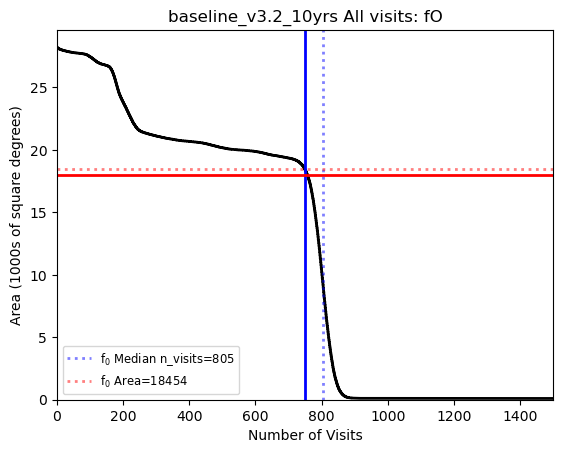

In [5]:
# Plot cumulative area covered to a minimum number of visits
plot_dict = {"asky":18000, "n_visits": 750}
fO.set_plot_dict(plot_dict)
fO.plot()

In this plot, the solid black line shows the amount of area observed with at least (a minimum of) X number of visits. The SRD details specify an area of sky (Asky) to be covered uniformly (see table 22), and then specifies a the *median* number of visits over Asky shall not be less than Nv1 (see table 23). 

The design goals for Asky and Nv1 are 18,000 sq degrees and 825 visits, with minimum values of 15,000 sq degrees and 750 visits. 
Due to choices made by the SCOC for survey strategy based on maximizing overall science return (see in particular the footprint choice in [PSTN-053](https://pstn-053.lsst.io) and then mini-survey choices in [PSTN-055](https://pstn-055.lsst.io)), the overall number of visits per pointing pushes below the design goal while the overall area remains at or above. 

The solid red and blue lines above indicate design AREA and minimum NVISIT SRD values. The dotted blue line indicates the *median* number of visits over the top 18,000 sq degrees (thus it intersects the solid red SRD-design-area line at a point offset from the solid black line indicating minimum number of visits per pointing over that area). The dotted red line indicates the area covered to a *minimum* of 750 visits per pointing. 

In [11]:
nv_med = np.where(fO.summary_values['fONv']['name'] == 'MedianNvis')[0]
nv_min = np.where(fO.summary_values['fONv']['name'] == 'MinNvis')[0]

names = ['fOArea (min 825 nvis)', 'fOArea (min 750 nvis)', 'fONv Median (over 18k sq deg)', 'fONv Minimum (over 18k sq deg)']
run_vals = [fO.summary_values['fOArea'], fO.summary_values['fOArea_750'], 
            fO.summary_values['fONv'][nv_med]['value'][0], fO.summary_values['fONv'][nv_min]['value'][0]]

pd.DataFrame(run_vals, names, columns=[run_name])

,baseline_v3.2_10yrs
fOArea (min 825 nvis),4384.470003
fOArea (min 750 nvis),18454.388671
fONv Median (over 18k sq deg),805.000000
fONv Minimum (over 18k sq deg),757.000000


While the `fOArea (min 750 nvis)` value above measured the area covered to a minimum of 750 visits, this could be interpreted as the most satisfactory interpretation of "uniformly covered" for Asky (and we would not use 825 visits per pointing, as this is both a design goal not a minimum goal, and also intended to represent the median number of visits per pointing, rather than the minimum number of visits per pointing over the footprint). 

Likewise, the `fONv Median (over 18k sq deg)` value above is the most satisfactory interpretation for the median visits per pointing over Asky area, and here we are using the design value of 18,000 sq degrees for the area (not the minimum area). 

In [12]:
print(f"Asky is {fO.summary_values['fOArea_750']}. Minimum requirement is 15000.")
print(f"NVis is {fO.summary_values['fONv'][nv_med]['value'][0]}. Minimum requirement is 750.")

Asky is 18454.388670903136. Minimum requirement is 15000.
NVis is 805.0. Minimum requirement is 750.


### Evaluate rapid revisit 

The requirement in the SRD and LSR is that timescales between 40 seconds and 30 minutes are "nearly uniformly" sampled. However, 'nearly uniformly' is poorly defined and also does not allow for overabundances of visits at some timescales such as those due to early returns for pairs of visits near 30 minutes. 

To try to encapsulate the spirit of the SRD requirement, the "RapidRevisit" metric was created, which looks for a minimum number of visits between 40 seconds and 30 minutes, with a further minimum of visits within 40 seconds minutes to 20 minutes. More visits are allowed between 20-30 minutes than in the first portion of the timeperiod, allowing for the overabundance due to pairs of visits. The metric result is 0 if that point on the sky does not satisfy the requirement, and '1' if it does. 

In [8]:
revisit_2 = revisit_bundles[f"{run_name.replace('.', '_')}_RapidRevisits_All_visits_HEAL"]

Rapid Revisit: area that receives at least 82 visits between 0.667 and 30.0 minutes, with at least 28 of those visits falling between 0.667 and 20.0 minutes. Summary statistic "Area" indicates the area on the sky which meets this requirement. (SRD design specification is 2000 sq deg).


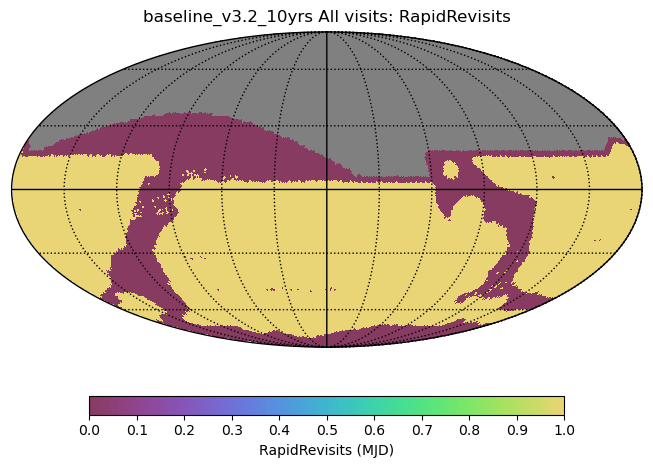

In [9]:
plot_dict = {'color_min': 0, 'color_max': 1}
revisit_2.set_plot_dict(plot_dict)
revisit_2.plot_funcs = [maf.HealpixSkyMap()]
revisit_2.plot()
print(revisit_2.display_dict['caption'])

In [10]:
print(f"Area meeting rapid revisit requirement: {revisit_2.summary_values}")

Area meeting rapid revisit requirement: {'Area (sq deg)': 29316.681807612375}


This requirement is easily met by all parts of the sky currently included in the 'main survey' portion of the sky. 